# Trigram model

In [1]:
# build training data set

In [2]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
words = open('../data/names.txt', 'r').read().splitlines()
vocabs = sorted(set(list(''.join(words)))) + ['.']
itoc = dict(enumerate(vocabs))
ctoi = {v:k for k,v in itoc.items()}
itoc[0], ctoi['a']
block_size = 3

In [4]:
# build training data set
def build_dataset(words):
    random.shuffle(words)
    X, Y = [], []
    for w in words:
        w = list(w) + ['.']
        context = [ctoi['.']] * block_size
        for y in w:
            X.append(context)
            Y.append(ctoi[y])
            context = context[1: ] + [ctoi[y]]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

X, Y = build_dataset(words)
n1 = int(X.shape[0] * 0.8) 
n2 = int(X.shape[0] * 0.9)
Xtr, Ytr = X[:n1], Y[:n1]
Xdev, Ydev = X[n1:n2], Y[n1:n2]
Xtest, Ytest = X[n2:], Y[n2:]

In [5]:
# implement lookup table

In [6]:
emb_dim = 10
h_dim = 200
n_word = len(vocabs) # 27

lockup_table = torch.randn((n_word, emb_dim))

W1 = torch.randn((emb_dim * block_size, h_dim)) * 5/3 / (emb_dim * block_size)**0.5
shift_std = torch.ones((1, h_dim))
shift_bias = torch.zeros((1, h_dim))
out_dim = len(vocabs)
W2 = torch.randn((h_dim, n_word)) / h_dim**0.5
b2 = torch.randn(n_word) * 0

running_std = torch.zeros((1, h_dim))
running_mean = torch.zeros((1, h_dim))

parameters = [lockup_table, W1, shift_std, shift_bias, W2, b2]
for p in parameters: p.requires_grad = True
sum([p.nelement() for p in parameters])

12097

In [7]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # forward
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    emb = lockup_table[Xtr[ix]].view((-1, emb_dim * block_size))
    hpreact = emb @ W1 # hidden layer pre-activated
    mean_hpreact = hpreact.mean(dim=0, keepdim=True)
    std_hpreact = hpreact.std(dim=0, keepdim=True)
    bnorm_hpreact = shift_std * (hpreact - mean_hpreact) / std_hpreact + shift_bias
    with torch.no_grad():
        running_std = running_std * 0.99 + 0.01 * std_hpreact
        running_mean = running_mean * 0.99 + 0.01 * mean_hpreact
    h = torch.tanh(bnorm_hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    lossi.append(loss.log10().item())
    # backward
    for p in parameters: p.grad = None
    loss.backward()
    lr = 0.1 if i < (max_steps/2) else 0.01
    for p in parameters: p.data += - lr * p.grad
    #track stats
    if i%10000==0:
        print(i, loss.item())
#     break

0 3.395040512084961
10000 2.1825714111328125
20000 2.2117159366607666
30000 2.196622371673584
40000 2.097360849380493
50000 2.0896904468536377
60000 1.9860931634902954
70000 1.7332866191864014
80000 2.117436408996582
90000 2.1771817207336426
100000 2.3184654712677
110000 2.6091866493225098
120000 1.9380015134811401
130000 2.1514837741851807
140000 1.9906511306762695
150000 2.2346701622009277
160000 2.629927635192871
170000 2.014700174331665
180000 1.9123154878616333
190000 2.270620584487915


In [8]:
def stats(x, name=''): print(name, x.mean(), x.std())
    
stats(emb, 'emb')
stats(W1, 'W1')
stats(emb @ W1, 'emb @ W1')
stats(h, 'h')
stats(logits, 'logits')
stats(bnorm_hpreact, 'bnorm_hpreact')

emb tensor(0.2563, grad_fn=<MeanBackward0>) tensor(0.9902, grad_fn=<StdBackward0>)
W1 tensor(0.0010, grad_fn=<MeanBackward0>) tensor(0.4454, grad_fn=<StdBackward0>)
emb @ W1 tensor(0.0594, grad_fn=<MeanBackward0>) tensor(2.4955, grad_fn=<StdBackward0>)
h tensor(-0.0064, grad_fn=<MeanBackward0>) tensor(0.6747, grad_fn=<StdBackward0>)
logits tensor(-0.0004, grad_fn=<MeanBackward0>) tensor(2.1218, grad_fn=<StdBackward0>)
bnorm_hpreact tensor(-0.0085, grad_fn=<MeanBackward0>) tensor(1.3525, grad_fn=<StdBackward0>)


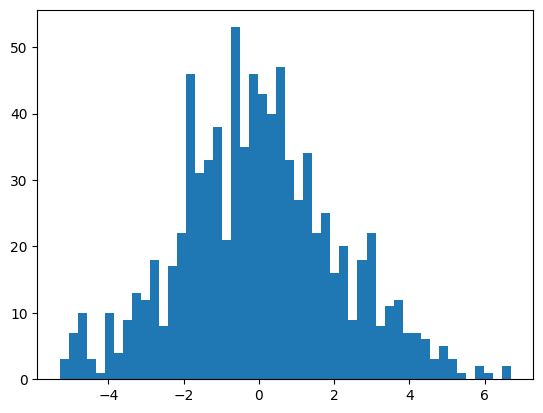

In [9]:
# problem with tanh
values = logits.view(-1).tolist()
_ = plt.hist(values, 50)

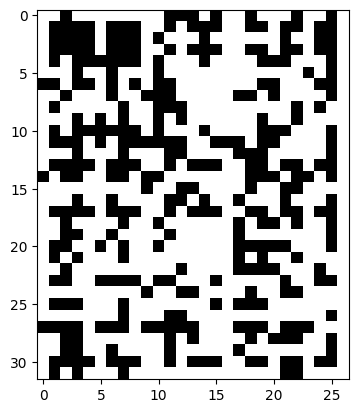

In [10]:
plt.imshow(logits.abs() > 0.99, cmap='gray', interpolation='nearest')

In [11]:
# mean and var
x = torch.randn((200, 10))
w = torch.randn((10, 100))
y = x@w
stats(x, 'x')
stats(y, 'y')

x tensor(-0.0208) tensor(1.0052)
y tensor(-0.0177) tensor(3.1190)


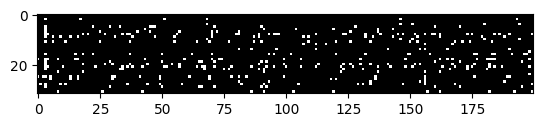

In [12]:
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [13]:
# high variance logit problem
logits = torch.randn(4) * 10; logits
probs = F.softmax(logits, 0); probs
print(probs)
-probs[0].log()

tensor([9.9974e-01, 8.1017e-08, 7.7448e-11, 2.6374e-04])


tensor(0.0003)

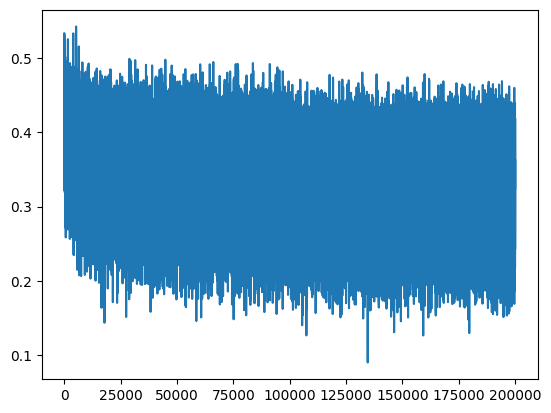

In [14]:
plt.plot(range(max_steps), lossi)

In [15]:
@torch.no_grad()
def split_loss(split):
    X, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }[split]
    emb = lockup_table[X].view((-1, emb_dim * block_size))
    hpreact = emb @ W1
    bnorm_hpreact = shift_std * (hpreact - running_mean) / running_std + shift_bias
    h = torch.tanh(bnorm_hpreact)
    out = h @ W2 + b2
    loss = F.cross_entropy(out, y)
    return loss.item()

print('train', split_loss('train'))
print('dev', split_loss('dev'))

train 2.0687389373779297
dev 2.1024153232574463


In [16]:
# fix over-confident
# train 2.114151954650879
# dev 2.1656265258789062
# fix init
# train 2.038177013397217
# dev 2.094085216522217
# add batch norm
# train 2.0689356327056885
# dev 2.1144886016845703

In [17]:
# sample from model
g = torch.Generator(device='cpu').manual_seed(2147483647)
for _ in range(15):
    chs = ['.'] * 3
    while True:
        x = [ctoi[c] for c in chs[-3:]]
        emb = lockup_table[x].view((-1, emb_dim * block_size))
        hpreact = emb @ W1
        bnorm_hpreact = shift_std * (hpreact - running_mean) / running_std + shift_bias
        h = torch.tanh(bnorm_hpreact)
        logits = h @ W2 + b2
        probs = torch.nn.functional.softmax(logits, 1)
        i = torch.multinomial(probs, 1, replacement = True, generator=g).item()
        chs.append(itoc[i])
        if chs[-1] == '.':
            print(''.join(chs[3:]))
            break

minai.
tason.
vivi.
kayaous.
nalynn.
aque.
kiya.
mackelthienna.
donna.
jhirlynn.
eli.
shoanei.
adali.
rajonna.
shonii.


### Convert this file to md

In [18]:
from IPython.core.display import Javascript

In [21]:
%%js
IPython.notebook.kernel.execute('this_notebook = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [22]:
this_notebook

'2022-11-29-trigram-part-2.ipynb'

In [23]:
!jupyter nbconvert --to markdown {this_notebook} --output-dir=../_posts

[NbConvertApp] Converting notebook 2022-11-29-trigram-part-2.ipynb to markdown
[NbConvertApp] Writing 5476 bytes to ../_posts/2022-11-29-trigram-part-2.md
